# 🕵️ CSI de los Datos: Detectives del Fraude (Pandas + IA)
**Bootcamp:** IA Innovador — Laboratorio guiado (3 h)  
**By:** Ing. Engler González

**Objetivo:** Investigar patrones sospechosos en transacciones usando **pandas** y (opcionalmente) **Gemini** para redactar una narrativa ejecutiva.

> **Nota:** El lab funciona 100% con *pandas* aunque no configures la IA.  
> Para usar IA, crea la variable de entorno `GOOGLE_API_KEY` en Colab: *Entorno de ejecución → Configurar variables de entorno → Añadir*.


## 0) Setup

In [17]:
!pip -q install pandas numpy matplotlib google-generativeai

import os, math, random, json, re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import google.generativeai as genai
from IPython.display import display

np.random.seed(7); pd.set_option("display.max_colwidth", 120)
# Retrieve the API key from Colab secrets
try:
    from google.colab import userdata
    api_key = userdata.get("GOOGLE_API_KEY")
except ImportError:
    # Fallback for environments where userdata is not available
    api_key = os.environ.get("GOOGLE_API_KEY")

model = None
# (Opcional IA) Configura tu GOOGLE_API_KEY en Entorno de ejecución > Variables de entorno
if api_key:
    genai.configure(api_key=api_key)
    model = genai.GenerativeModel("gemini-1.5-flash")
    print("✅ Gemini model configured.")
else:
    print("❌ GOOGLE_API_KEY not found. Gemini model not configured.")

✅ Gemini model configured.


## 1) Generar dataset sintético
No necesitas archivos. Simularemos **60 días** de transacciones en múltiples países y canales. Inyectaremos anomalías a propósito (madrugada, montos altos, duplicados, valores faltantes).


In [18]:
# Escenario: transacciones de 60 días. Inyectamos anomalías.
n = 6000
countries = ["CO", "MX", "US", "AR", "CL", "ES"]
channels = ["web", "app", "social_ads", "affiliate", "email"]

# Distribución de horas por tramos (más peso en el día). Normalizamos para que sume 1.
hour_weights = [0.02]*6 + [0.04]*6 + [0.06]*6 + [0.02]*6  # 0-5, 6-11, 12-17, 18-23
hour_weights = np.array(hour_weights, dtype=float)
hour_weights = hour_weights / hour_weights.sum()

hours = np.random.choice(range(0,24), size=n, p=hour_weights)
base_amount = np.random.lognormal(mean=3.3, sigma=0.5, size=n) * 10  # distribución sesgada
country = np.random.choice(countries, size=n, p=[0.32,0.20,0.16,0.12,0.12,0.08])
channel = np.random.choice(channels, size=n, p=[0.35,0.25,0.15,0.15,0.10])
user_id = np.random.randint(1000, 5000, size=n)
days = pd.date_range(end=pd.Timestamp.today().normalize(), periods=60)
timestamp = np.random.choice(days, size=n) + pd.to_timedelta(hours, unit="h")

# Inyectar patrones sospechosos
amount = base_amount.copy()
mask_night = (hours < 6) | (hours > 22)
amount[mask_night] *= np.random.uniform(1.4, 2.1, size=mask_night.sum())  # montos más altos de madrugada

mask_remote = np.isin(country, ["ES","US"]) & np.isin(channel, ["affiliate","social_ads"])
amount[mask_remote] *= np.random.uniform(1.2, 1.8, size=mask_remote.sum())

# Outliers y duplicados
idx_out = np.random.choice(range(n), size=40, replace=False)
amount[idx_out] *= np.random.uniform(3, 10, size=40)
duplicated_rows = 30
dups = np.random.choice(range(n), size=duplicated_rows, replace=False)

df = pd.DataFrame({
    "transaction_id": [f"T{100000+i}" for i in range(n)],
    "user_id": user_id,
    "amount": amount.round(2),
    "country": country,
    "channel": channel,
    "timestamp": timestamp
})
df = pd.concat([df, df.iloc[dups]], ignore_index=True)  # añadir duplicados

# Nulos/errores de formato
df.loc[np.random.choice(df.index, 50, replace=False), "channel"] = None
df.loc[np.random.choice(df.index, 30, replace=False), "country"] = "??"
df.loc[np.random.choice(df.index, 20, replace=False), "amount"] = None

print("✅ Dataset generado:", df.shape)
df.head()

✅ Dataset generado: (6030, 6)


,transaction_id,user_id,amount,country,channel,timestamp
0,T100000,4140,511.60,CO,web,2025-07-09 03:00:00
1,T100001,4078,171.44,CO,app,2025-08-06 16:00:00
2,T100002,1095,241.59,CL,email,2025-07-18 12:00:00
3,T100003,2871,216.57,CO,app,2025-06-30 16:00:00
4,T100004,2232,504.38,CO,affiliate,2025-08-16 23:00:00


## 2) Limpieza de datos (GUIADA)
**TODOs**  
1. Revisar info general, nulos y duplicados.  
2. Eliminar duplicados exactos.  
3. Asegurar tipos correctos (`timestamp` → datetime, `amount` → float).  
4. Normalizar categorías (reemplazar `"??"` por `NaN`, decidir imputación/filtrado).  
5. Tratar nulos en `amount` y `channel` (documentar la decisión).


In [19]:
# Punto de partida y pistas ---
df.info()
print("\nNulos antes:", df.isna().sum())
df.isna().mean().sort_values(ascending=False).head(10)

print("\nDuplicados antes:", df.duplicated().sum())
df = df.drop_duplicates()
df["timestamp"] = pd.to_datetime(df["timestamp"], errors="coerce")
df["amount"] = pd.to_numeric(df["amount"], errors="coerce")
df["country"] = df["country"].replace("??", np.nan)

#Treat nulls in 'amount' and 'channel'
#For 'amount', we can fill with the median as it's less sensitive to outliers than the mean.
df["amount"] = df["amount"].fillna(df["amount"].median())
#For 'channel', we can fill with a placeholder like 'unknown' as it's a categorical variable.
df["channel"] = df["channel"].fillna("unknown")

print("\nNulos después:", df.isna().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6030 entries, 0 to 6029
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   transaction_id  6030 non-null   object        
 1   user_id         6030 non-null   int64         
 2   amount          6010 non-null   float64       
 3   country         6030 non-null   object        
 4   channel         5980 non-null   object        
 5   timestamp       6030 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(1), object(3)
memory usage: 282.8+ KB

Nulos antes: transaction_id     0
user_id            0
amount            20
country            0
channel           50
timestamp          0
dtype: int64

Duplicados antes: 29

Nulos después: transaction_id     0
user_id            0
amount             0
country           30
channel            0
timestamp          0
dtype: int64


## 3) EDA: entender el comportamiento
**TODOs**  
6. Crear columnas derivadas: `hour`, `day_of_week`.  
7. Resúmenes clave:  
   - monto promedio por país  
   - distribución por canal  
   - actividad por hora  
   - top usuarios por monto total (opcional)


Monto promedio por país:


,amount
country,
US,427.828019
ES,418.637956
CL,360.052394
CO,354.997947
MX,349.753926
AR,344.071766



Distribución por canal:


,count
channel,
web,2146
app,1418
social_ads,895
affiliate,881
email,611
unknown,50



Actividad por hora:


,transaction_id
hour,
0,135
1,134
2,150
3,155
4,139
5,138
6,309
7,291
8,298


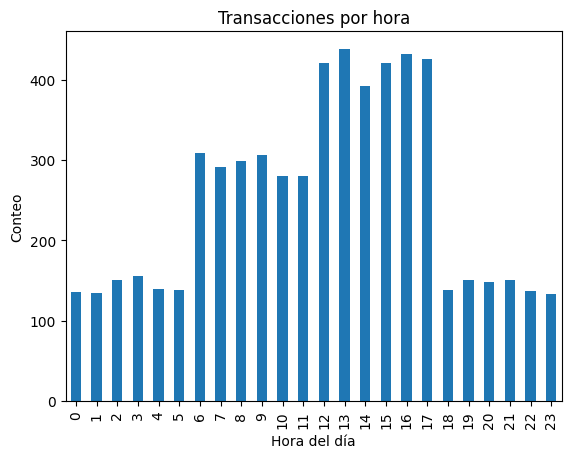

In [20]:
df["hour"] = df["timestamp"].dt.hour
df["day_of_week"] = df["timestamp"].dt.day_name()

mean_by_country = df.groupby("country", dropna=True)["amount"].mean().sort_values(ascending=False)
count_by_channel = df["channel"].value_counts(dropna=False)
activity_by_hour = df.groupby("hour")["transaction_id"].count()

print("Monto promedio por país:"); display(mean_by_country.head(10))
print("\nDistribución por canal:"); display(count_by_channel)
print("\nActividad por hora:"); display(activity_by_hour.head(24))

# Gráfico simple (matplotlib)
plt.figure()
activity_by_hour.plot(kind="bar")
plt.title("Transacciones por hora")
plt.xlabel("Hora del día")
plt.ylabel("Conteo")
plt.show()

## 4) Detección de outliers y reglas de sospecha
**TODOs**  
8. Detectar outliers por IQR en `amount`.  
9. Crear reglas heurísticas (ajusta umbrales con tu EDA):  
   - madrugada (`hour` < 6 o > 22) con `amount` > p95  
   - `affiliate`/`social_ads` con `amount` > p95  
   - `country` o `channel` nulos con `amount` > p95  
10. Construir un **score de sospecha** sumando reglas (0–3/4).


In [21]:
q1, q3 = df["amount"].quantile([0.25, 0.75])
iqr = q3 - q1
lower, upper = q1 - 1.5*iqr, q3 + 1.5*iqr
df["is_outlier_amount"] = (df["amount"] < lower) | (df["amount"] > upper)

p95 = df["amount"].quantile(0.95)
df["is_night"] = (df["hour"] < 6) | (df["hour"] > 22)
df["rule_night_high"] = df["is_night"] & (df["amount"] > p95)
df["rule_affiliate_high"] = df["channel"].isin(["affiliate","social_ads"]) & (df["amount"] > p95)
df["rule_missing_high"] = (df["country"].isna() | df["channel"].isna()) & (df["amount"] > p95)

rule_cols = ["is_outlier_amount","rule_night_high","rule_affiliate_high","rule_missing_high"]
df["suspicion_score"] = df[rule_cols].sum(axis=1)

df[["amount","hour","country","channel","is_outlier_amount","rule_night_high","rule_affiliate_high","rule_missing_high","suspicion_score"]].head(10)

,amount,hour,country,channel,is_outlier_amount,rule_night_high,rule_affiliate_high,rule_missing_high,suspicion_score
0,511.60,3,CO,web,False,False,False,False,0
1,171.44,16,CO,app,False,False,False,False,0
2,241.59,12,CL,email,False,False,False,False,0
3,216.57,16,CO,app,False,False,False,False,0
4,504.38,23,CO,affiliate,False,False,False,False,0
5,685.71,13,US,web,False,False,False,False,0
6,340.91,13,ES,email,False,False,False,False,0
7,225.65,3,AR,web,False,False,False,False,0
8,691.64,8,CO,app,False,False,False,False,0
9,326.09,12,ES,email,False,False,False,False,0


## 5) Ranking de casos y explicación
**TODOs**  
11. Ordena por `suspicion_score` y revisa el **Top 20**. Escribe 3 observaciones.


In [22]:
top_cases = df.sort_values(["suspicion_score","amount"], ascending=[False, False]).head(20)
top_cases[["transaction_id","user_id","amount","country","channel","hour","suspicion_score"]]

,transaction_id,user_id,amount,country,channel,hour,suspicion_score
504,T100504,2332,3421.63,US,affiliate,0,3
5013,T105013,4560,2957.98,US,social_ads,3,3
1587,T101587,1179,2506.48,MX,affiliate,3,3
832,T100832,2218,2472.13,CO,social_ads,0,3
413,T100413,1008,2132.67,US,affiliate,23,3
1473,T101473,3129,2131.12,US,social_ads,5,3
4381,T104381,3209,1983.10,CO,social_ads,4,3
5343,T105343,4885,1805.96,ES,social_ads,1,3
304,T100304,2043,1733.04,ES,social_ads,2,3
5005,T105005,3008,1647.44,CO,social_ads,0,3


## 6) (Opcional) IA para narrativa ejecutiva
Si tienes `GOOGLE_API_KEY`, genera un *brief* de 6 líneas para directivos con patrones, acciones y métricas.


In [23]:
if model:
    resumen_stats = {
        "p95_amount": float(p95),
        "outlier_rate": float(df["is_outlier_amount"].mean()),
        "night_rate": float(df["is_night"].mean()),
        "top_channels": df["channel"].value_counts().head(3).to_dict()
    }
    prompt = f"""
    Eres analista forense de datos. Con base en:
    Stats: {json.dumps(resumen_stats)}
    Reglas aplicadas: {rule_cols}
    Redacta un briefing ejecutivo (6 líneas) explicando:
    - Qué patrones sugieren posible fraude
    - Acciones inmediatas (reglas de negocio, límites, monitoreo)
    - Métricas a vigilar la próxima semana
    """
    print(model.generate_content(prompt).text)
else:
    print("⚠️ IA no configurada. El análisis se puede entregar igual con pandas y gráficos.")

El análisis de datos revela un 5% de transacciones con valores atípicos, alcanzando un percentil 95 de 793.61.  Un 16% de las transacciones ocurren de noche, sugiriendo posible actividad fraudulenta.  Las reglas 'is_outlier_amount' y 'rule_night_high' activaron alertas.  Se recomienda revisar inmediatamente las transacciones nocturnas y atípicas, ajustando los límites máximos de transacción y fortaleciendo la regla 'rule_night_high'.  Se debe monitorear el `outlier_rate` y `night_rate` semanalmente, además del volumen de transacciones por canal (especialmente 'web').



## 7) Reto final (entrega)
12. Ajusta y compara umbrales (`p90`/`p95`/`p99`).  
13. Añade más países y **1 regla nueva** por país-hora.  
14. Genera **2 gráficos** que respalden tus reglas (ej: día vs noche, por canal).  
15. Redacta **5 conclusiones numeradas**.


In [24]:
print("🧩 Reto final: ajusta umbrales, agrega 1 regla nueva, 2 gráficos y 5 conclusiones.")

🧩 Reto final: ajusta umbrales, agrega 1 regla nueva, 2 gráficos y 5 conclusiones.


In [25]:
# Escenario: transacciones de 60 días. Inyectamos anomalías.
n = 6000
countries = ["CO", "MX", "US", "AR", "CL", "ES"]
channels = ["web", "app", "social_ads", "affiliate", "email"]

# Distribución de horas por tramos (más peso en el día). Normalizamos para que sume 1.
hour_weights = [0.02]*6 + [0.04]*6 + [0.06]*6 + [0.02]*6  # 0-5, 6-11, 12-17, 18-23
hour_weights = np.array(hour_weights, dtype=float)
hour_weights = hour_weights / hour_weights.sum()

hours = np.random.choice(range(0,24), size=n, p=hour_weights)
base_amount = np.random.lognormal(mean=3.3, sigma=0.5, size=n) * 10  # distribución sesgada
country = np.random.choice(countries, size=n, p=[0.32,0.20,0.16,0.12,0.12,0.08])
channel = np.random.choice(channels, size=n, p=[0.35,0.25,0.15,0.15,0.10])
user_id = np.random.randint(1000, 5000, size=n)
days = pd.date_range(end=pd.Timestamp.today().normalize(), periods=60)
timestamp = np.random.choice(days, size=n) + pd.to_timedelta(hours, unit="h")

# Inyectar patrones sospechosos
amount = base_amount.copy()
mask_night = (hours < 6) | (hours > 22)
amount[mask_night] *= np.random.uniform(1.4, 2.1, size=mask_night.sum())  # montos más altos de madrugada

mask_remote = np.isin(country, ["ES","US"]) & np.isin(channel, ["affiliate","social_ads"])
amount[mask_remote] *= np.random.uniform(1.2, 1.8, size=mask_remote.sum())

# Outliers y duplicados
idx_out = np.random.choice(range(n), size=40, replace=False)
amount[idx_out] *= np.random.uniform(3, 10, size=40)
duplicated_rows = 30
dups = np.random.choice(range(n), size=duplicated_rows, replace=False)

df = pd.DataFrame({
    "transaction_id": [f"T{100000+i}" for i in range(n)],
    "user_id": user_id,
    "amount": amount.round(2),
    "country": country,
    "channel": channel,
    "timestamp": timestamp
})
df = pd.concat([df, df.iloc[dups]], ignore_index=True)  # añadir duplicados

# Nulos/errores de formato
df.loc[np.random.choice(df.index, 50, replace=False), "channel"] = None
df.loc[np.random.choice(df.index, 30, replace=False), "country"] = "??"
df.loc[np.random.choice(df.index, 20, replace=False), "amount"] = None

print("✅ Dataset generado:", df.shape)
df.head()

✅ Dataset generado: (6030, 6)


,transaction_id,user_id,amount,country,channel,timestamp
0,T100000,3037,711.89,CO,app,2025-08-03 01:00:00
1,T100001,1355,424.57,AR,app,2025-08-01 06:00:00
2,T100002,2780,313.38,US,web,2025-08-11 16:00:00
3,T100003,4599,304.97,CO,social_ads,2025-08-11 12:00:00
4,T100004,1840,249.61,CO,web,2025-07-16 14:00:00


In [26]:
df.info()
print("\nNulos antes:", df.isna().sum())
df.isna().mean().sort_values(ascending=False).head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6030 entries, 0 to 6029
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   transaction_id  6030 non-null   object        
 1   user_id         6030 non-null   int64         
 2   amount          6010 non-null   float64       
 3   country         6030 non-null   object        
 4   channel         5980 non-null   object        
 5   timestamp       6030 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(1), object(3)
memory usage: 282.8+ KB

Nulos antes: transaction_id     0
user_id            0
amount            20
country            0
channel           50
timestamp          0
dtype: int64


,0
channel,0.008292
amount,0.003317
user_id,0.000000
transaction_id,0.000000
country,0.000000
timestamp,0.000000


In [27]:
if model:
    resumen_stats = {
        "p95_amount": float(p95),
        "outlier_rate": float(df["is_outlier_amount"].mean()),
        "night_rate": float(df["is_night"].mean()),
        "top_channels": df["channel"].value_counts().head(3).to_dict()
    }
    prompt = f"""
    Eres analista forense de datos. Con base en:
    Stats: {json.dumps(resumen_stats)}
    Reglas aplicadas: {rule_cols}
    Redacta un briefing ejecutivo (6 líneas) explicando:
    - Qué patrones sugieren posible fraude
    - Acciones inmediatas (reglas de negocio, límites, monitoreo)
    - Métricas a vigilar la próxima semana
    """
    print(model.generate_content(prompt).text)
else:
    print("⚠️ IA no configurada. El análisis se puede entregar igual con pandas y gráficos.")

KeyError: 'is_outlier_amount'